In [11]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os


# ============================================================
# SVD Image Compression (Learning Version)
# ============================================================
# What you will learn:
# 1) Image -> Matrix
# 2) Matrix -> SVD (U, S, Vt)
# 3) Keep only top-k singular values (compression)
# 4) Reconstruct approximate image
# 5) Compare storage and quality
# ============================================================


In [12]:
def load_image_as_grayscale_matrix(image_path: str) -> np.ndarray:
    """
    Step 1: Load image, convert to grayscale, and return as a float matrix.
    Pixel values will be in range [0, 255].
    """
    img = Image.open(image_path).convert("L")  # "L" = grayscale
    A = np.array(img, dtype=np.float64)
    return A



In [13]:
def svd_compress(A: np.ndarray, k: int) -> np.ndarray:
    """
    Step 2-4: Perform SVD and create rank-k approximation of A.
    A ≈ U_k @ diag(S_k) @ Vt_k
    """
    # Step 2: SVD
    # full_matrices=False makes shapes compact and faster
    U, S, Vt = np.linalg.svd(A, full_matrices=False)

    # Step 3: Keep only top-k components
    U_k = U[:, :k]               # (m x k)
    S_k = np.diag(S[:k])         # (k x k)
    Vt_k = Vt[:k, :]             # (k x n)

    # Step 4: Reconstruct compressed matrix
    A_approx = U_k @ S_k @ Vt_k

    # Clip values back to valid pixel range
    A_approx = np.clip(A_approx, 0, 255)
    return A_approx


In [14]:
def storage_stats(m: int, n: int, k: int) -> dict:
    """
    Step 5: Compare how many numbers we store.
    Original image stores m*n numbers.
    SVD rank-k stores: U(m*k) + S(k) + Vt(k*n) numbers
    (S is stored as k singular values, not full kxk matrix)
    """
    original = m * n
    compressed = (m * k) + k + (k * n)
    ratio = original / compressed
    saved_pct = 100.0 * (1.0 - (compressed / original))

    return {
        "original_numbers": original,
        "compressed_numbers": compressed,
        "compression_ratio_x": ratio,
        "space_saved_percent": saved_pct
    }



In [15]:
def save_matrix_as_image(A: np.ndarray, out_path: str):
    """
    Save a matrix as a grayscale image.
    """
    img = Image.fromarray(A.astype(np.uint8), mode="L")
    img.save(out_path)



In [18]:
def main():
    # --------------------------------------------
    # CHANGE THIS PATH to your local file path
    # Example: r"D:\images\cricket_pic_1.jpg"
    # --------------------------------------------
    image_path = r"d:/datasets/dpp/sachin-tendulkar-pic.jpg"  # container path; replace when running locally

    # Step 1: Load image -> matrix
    A = load_image_as_grayscale_matrix(image_path)
    m, n = A.shape

    print("=== 1) Original Image as Matrix ===")
    print(f"Image shape (rows x cols): {m} x {n}")
    print(f"Total numbers to store originally: {m*n}")

    # Step 2: Show singular values (optional but educational)
    print("\n=== 2) Singular Values Overview (first 20) ===")
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    print(np.round(S[:20], 2))

    # Choose k values for learning
    # Smaller k = more compression but blurrier
    k_values = [10, 25, 50, 100, 200]

    # Output folder
    out_dir = "svd_outputs"
    os.makedirs(out_dir, exist_ok=True)

    # Save original
    original_out = os.path.join(out_dir, "original_grayscale.png")
    save_matrix_as_image(A, original_out)

    # Compress and save results
    compressed_images = []
    stats_list = []

    print("\n=== 3) Compression Results ===")
    for k in k_values:
        k = min(k, min(m, n))  # safety: k cannot exceed min(m,n)
        A_k = svd_compress(A, k)

        out_path = os.path.join(out_dir, f"compressed_k_{k}.png")
        save_matrix_as_image(A_k, out_path)

        stats = storage_stats(m, n, k)
        stats_list.append((k, stats, out_path))
        compressed_images.append((k, A_k))

        print(f"\n--- Rank-k = {k} ---")
        print(f"Compressed image saved to: {out_path}")
        print(f"Original numbers:   {stats['original_numbers']}")
        print(f"Compressed numbers: {stats['compressed_numbers']}  (U:{m*k} + S:{k} + Vt:{k*n})")
        print(f"Compression ratio:  {stats['compression_ratio_x']:.2f}x")
        print(f"Space saved:        {stats['space_saved_percent']:.2f}%")

    # Step 4: Visual comparison in one figure
    print("\n=== 4) Showing Comparison Plot ===")
    cols = 3
    rows = int(np.ceil((len(k_values) + 1) / cols))
    plt.figure(figsize=(12, 4 * rows))

    # Original
    plt.subplot(rows, cols, 1)
    plt.imshow(A, cmap="gray")
    plt.title("Original (Grayscale)")
    plt.axis("off")

    # Compressed versions
    for idx, (k, A_k) in enumerate(compressed_images, start=2):
        plt.subplot(rows, cols, idx)
        plt.imshow(A_k, cmap="gray")
        plt.title(f"SVD Compressed (k={k})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"\nDone. Outputs saved in folder: {out_dir}")
    print(f"Original grayscale saved as: {original_out}")


=== 1) Original Image as Matrix ===
Image shape (rows x cols): 275 x 220
Total numbers to store originally: 60500

=== 2) Singular Values Overview (first 20) ===
[27211.93  4459.52  3348.41  2255.31  2034.48  1724.09  1633.72  1409.08
  1181.35  1092.99  1049.53   961.51   923.93   872.55   782.6    747.25
   700.76   691.85   622.02   598.34]

=== 3) Compression Results ===

--- Rank-k = 10 ---
Compressed image saved to: svd_outputs\compressed_k_10.png
Original numbers:   60500
Compressed numbers: 4960  (U:2750 + S:10 + Vt:2200)
Compression ratio:  12.20x
Space saved:        91.80%

--- Rank-k = 25 ---
Compressed image saved to: svd_outputs\compressed_k_25.png
Original numbers:   60500
Compressed numbers: 12400  (U:6875 + S:25 + Vt:5500)
Compression ratio:  4.88x
Space saved:        79.50%

--- Rank-k = 50 ---
Compressed image saved to: svd_outputs\compressed_k_50.png
Original numbers:   60500
Compressed numbers: 24800  (U:13750 + S:50 + Vt:11000)
Compression ratio:  2.44x
Space saved

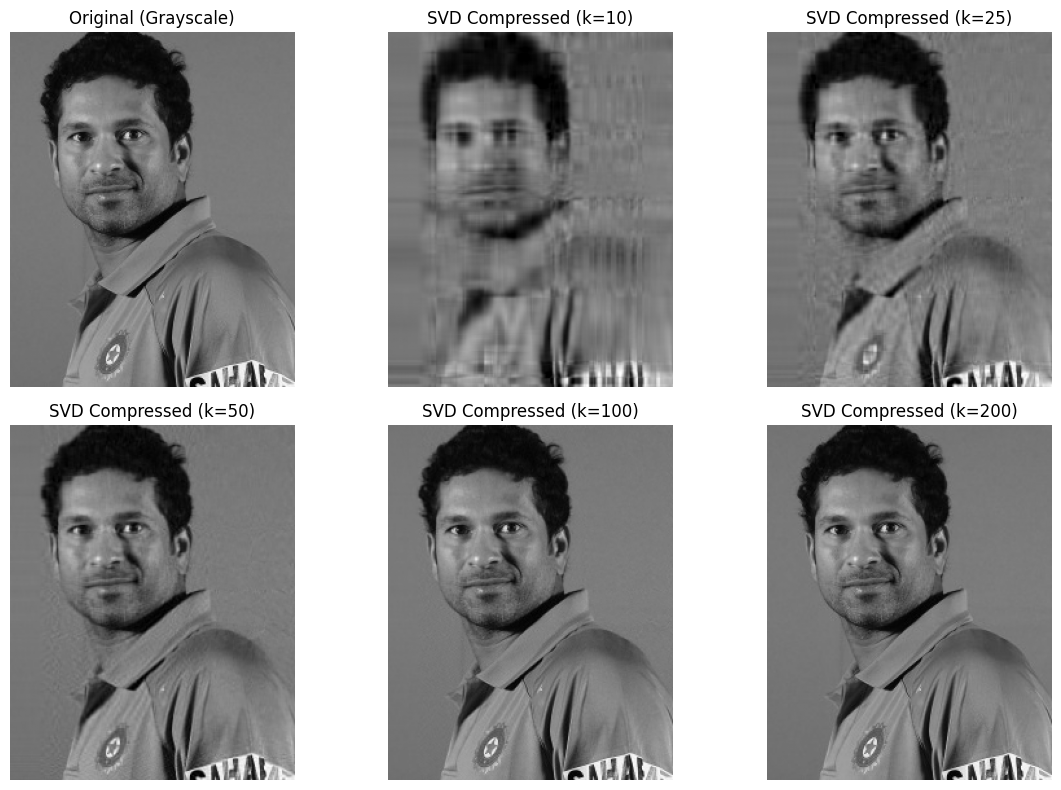


Done. Outputs saved in folder: svd_outputs
Original grayscale saved as: svd_outputs\original_grayscale.png


In [19]:
if __name__ == "__main__":
    main()
